In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import warnings
warnings.filterwarnings(action = 'ignore')
pd.pandas.set_option('display.max_columns', None)

In [2]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('house_price.csv') 

In [4]:
df.head()

,Location,BHK,Furnishing,Sq.ft,Old(years),Floor,Price
0,Bommanahalli,3,1,3000,1,3,28000
1,Bommanahalli,3,1,1650,10,0,18000
2,Whitefield,2,0,1000,5,3,16400
3,Whitefield,3,0,1600,1,9,27000
4,Whitefield,2,1,1200,5,1,20000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Location    1000 non-null   object
 1   BHK         1000 non-null   int64 
 2   Furnishing  1000 non-null   int64 
 3   Sq.ft       1000 non-null   int64 
 4   Old(years)  1000 non-null   int64 
 5   Floor       1000 non-null   int64 
 6   Price       1000 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 54.8+ KB


In [6]:
df.shape

(1000, 7)

In [7]:
df.describe(include='all')

,Location,BHK,Furnishing,Sq.ft,Old(years),Floor,Price
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,Bommanahalli,NaN,NaN,NaN,NaN,NaN,NaN
freq,504,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.436000,0.348000,1448.613000,4.029000,3.465000,22829.900000
std,NaN,0.496135,0.476574,491.272535,3.048845,3.245197,7706.410627
min,NaN,2.000000,0.000000,767.000000,1.000000,0.000000,11000.000000
25%,NaN,2.000000,0.000000,1089.000000,1.000000,1.000000,16500.000000
50%,NaN,2.000000,0.000000,1300.000000,5.000000,3.000000,21000.000000
75%,NaN,3.000000,1.000000,1650.000000,5.000000,3.000000,26000.000000


### missing values

In [8]:
df.isnull().sum()

Location      0
BHK           0
Furnishing    0
Sq.ft         0
Old(years)    0
Floor         0
Price         0
dtype: int64

### outliers 

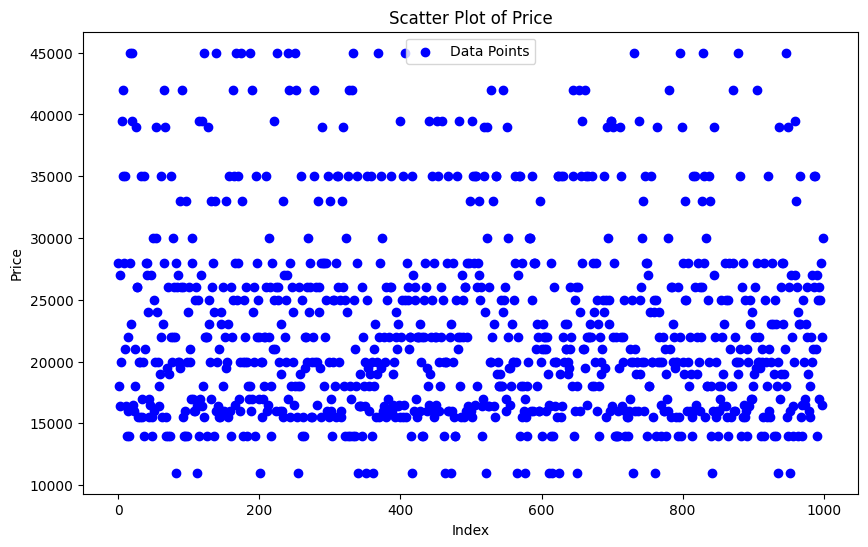

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['Price'], color='blue', label='Data Points')
plt.title('Scatter Plot of Price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
def outlier_(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1

    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr

    col = col.apply(lambda x: upper_limit if x > upper_limit else (lower_limit if x < lower_limit else x))
    
    return col

In [11]:
df['Price'] = outlier_(df['Price'])

<AxesSubplot:xlabel='Price'>

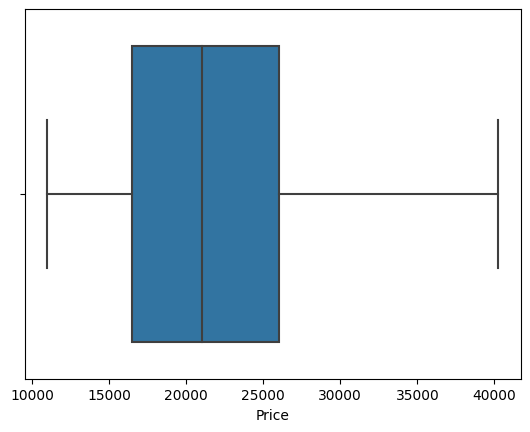

In [12]:
sns.boxplot(x=df['Price'])

In [13]:
obj_cols = []
num_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        obj_cols.append(col)
    else:
        num_cols.append(col)
num_cols.remove('Price')

In [14]:
print(obj_cols)
print(num_cols)

['Location']
['BHK', 'Furnishing', 'Sq.ft', 'Old(years)', 'Floor']


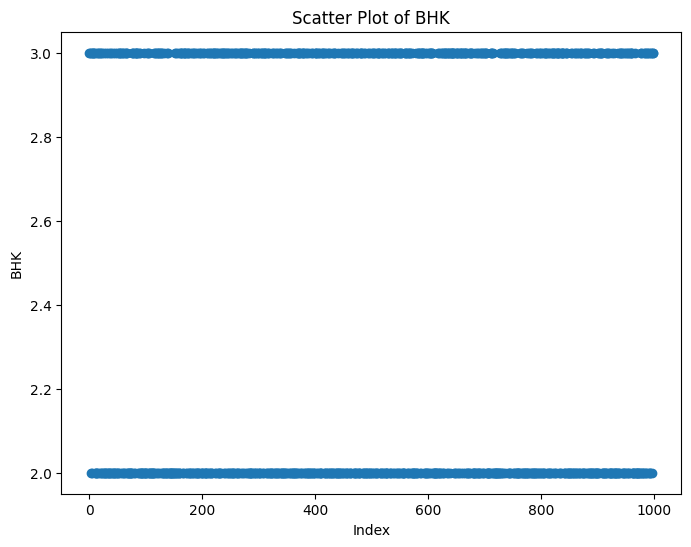

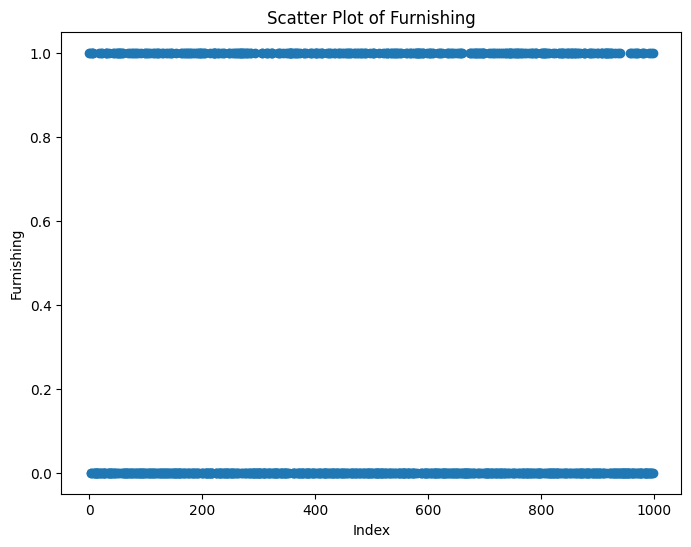

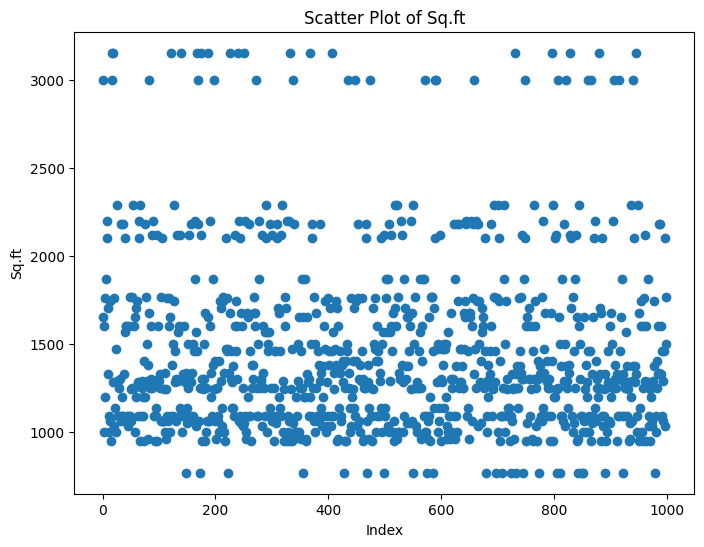

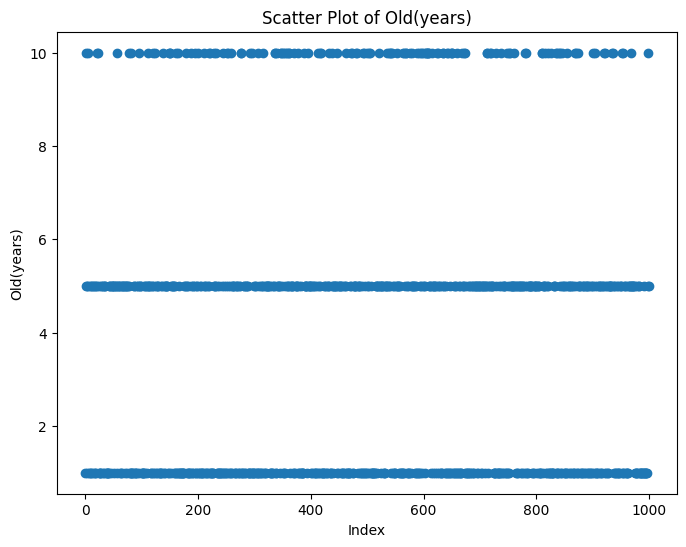

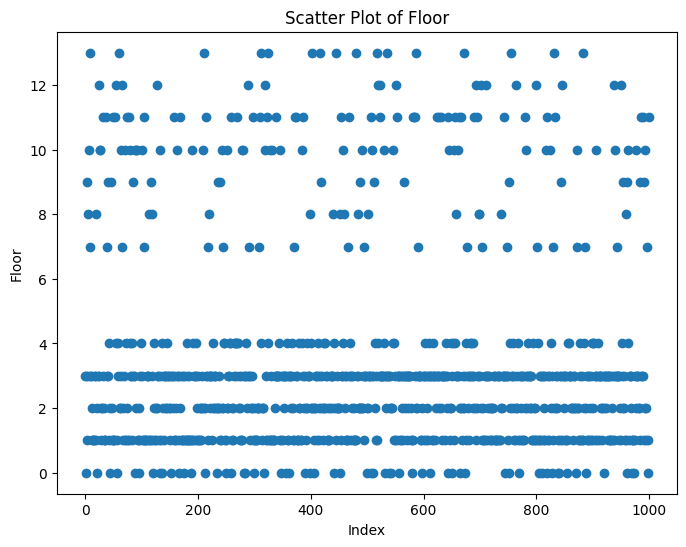

In [15]:
for col in num_cols:
    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(df[col])), df[col]) 
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.title(f'Scatter Plot of {col}')
    plt.show()

In [16]:
for col in num_cols:
    df[col] = outlier_(df[col])

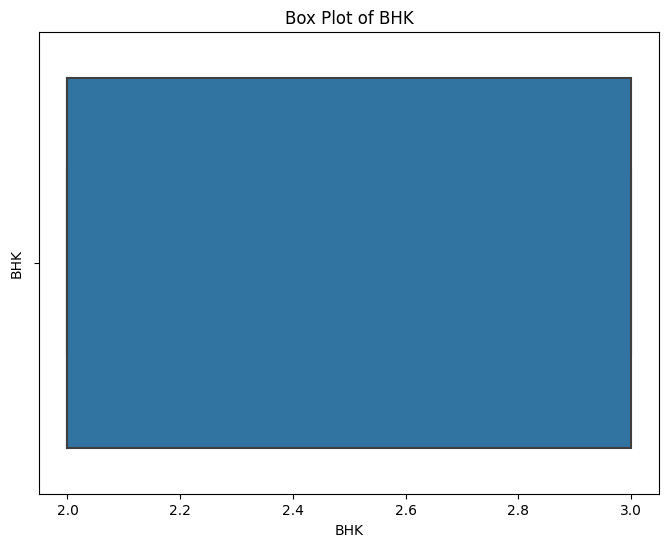

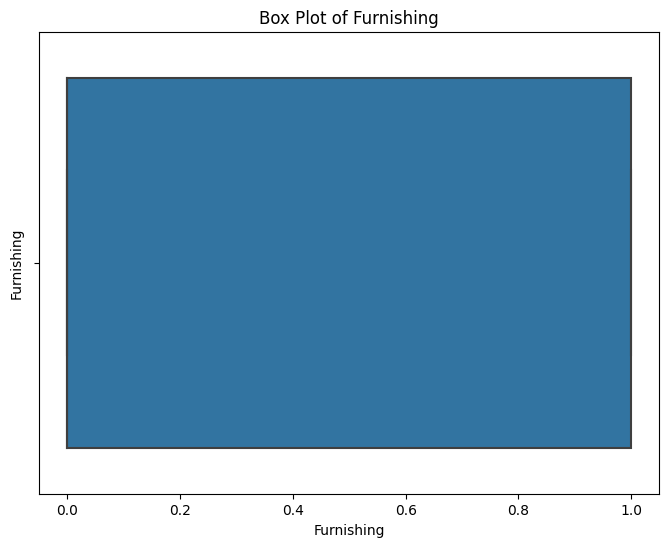

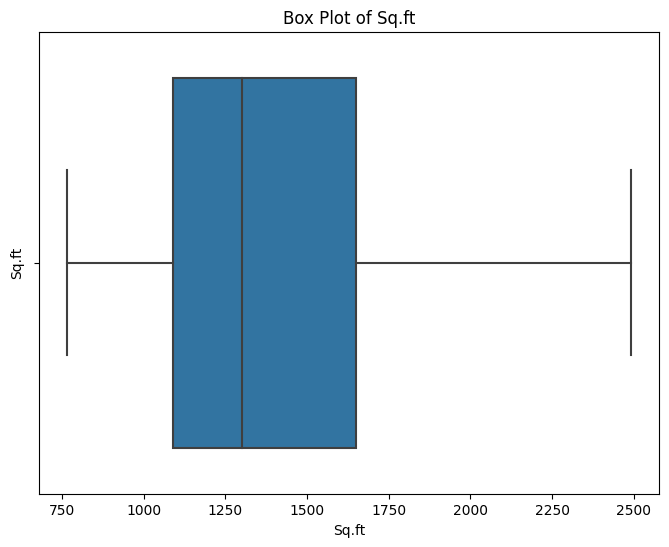

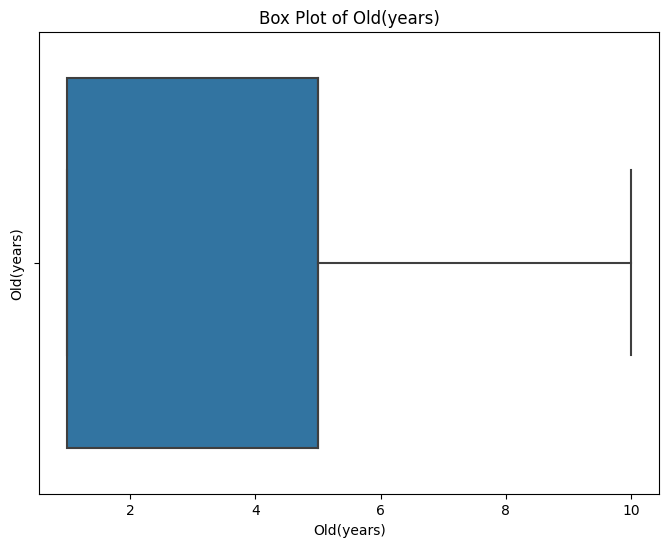

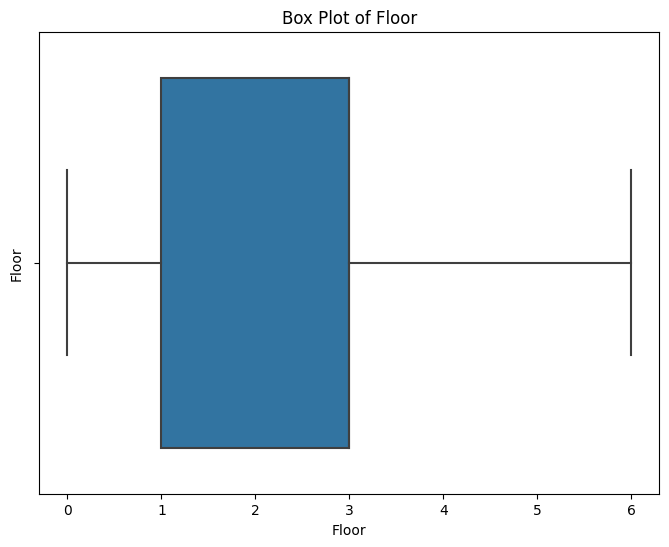

In [17]:
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])  
    plt.ylabel(col)
    plt.title(f'Box Plot of {col}')
    plt.show()

In [18]:
df.head()

,Location,BHK,Furnishing,Sq.ft,Old(years),Floor,Price
0,Bommanahalli,3,1,2491.5,1,3.0,28000.0
1,Bommanahalli,3,1,1650.0,10,0.0,18000.0
2,Whitefield,2,0,1000.0,5,3.0,16400.0
3,Whitefield,3,0,1600.0,1,6.0,27000.0
4,Whitefield,2,1,1200.0,5,1.0,20000.0


### visualizations

In [19]:
def plot_continuous_distribution(data: pd.DataFrame = None, column: str = None, height: int = 8):
  _ = sns.displot(data, x=column, kde=True, height=height, aspect=height/5).set(title=f'Distribution of {column}');

def get_unique_values(data, column):
  num_unique_values = len(data[column].unique())
  value_counts = data[column].value_counts()
  print(f"Column: {column} has {num_unique_values} unique values\n")
  print(value_counts)
    
def plot_categorical_distribution(data: pd.DataFrame = None, column: str = None, height: int = 8, aspect: int = 2, top_categories: int = 5):
    top_categories_data = data[column].value_counts().nlargest(top_categories)
    plt.figure(figsize=(height, height/aspect))
    sns.countplot(data=data[data[column].isin(top_categories_data.index)], x=column, order=top_categories_data.index)
    plt.title(f'Top Categories in {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

In [20]:
for col in obj_cols:
    get_unique_values(df, col)

Column: Location has 2 unique values

Bommanahalli    504
Whitefield      496
Name: Location, dtype: int64


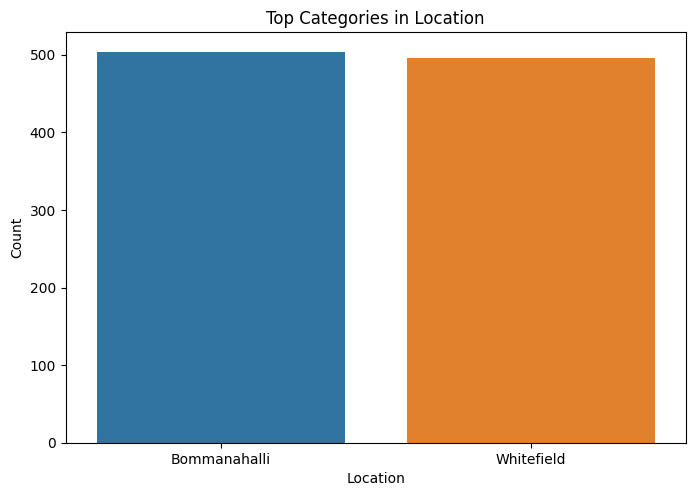

In [21]:
for col in obj_cols:
    plot_categorical_distribution(df, col, height = 8, aspect = 1.5)

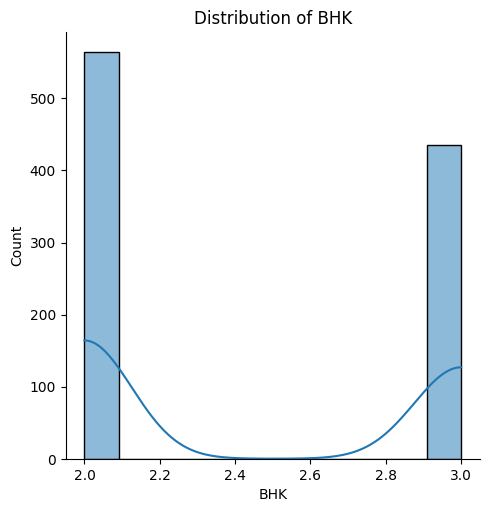

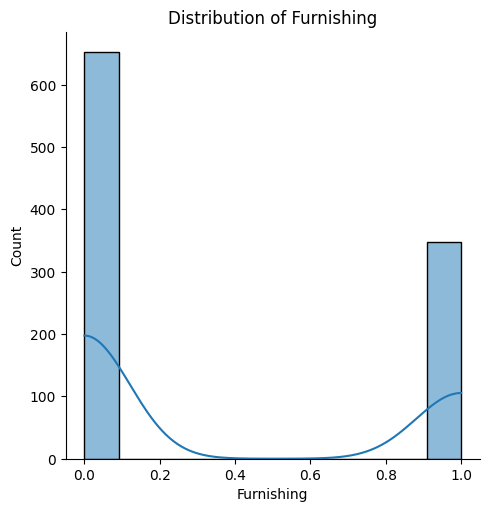

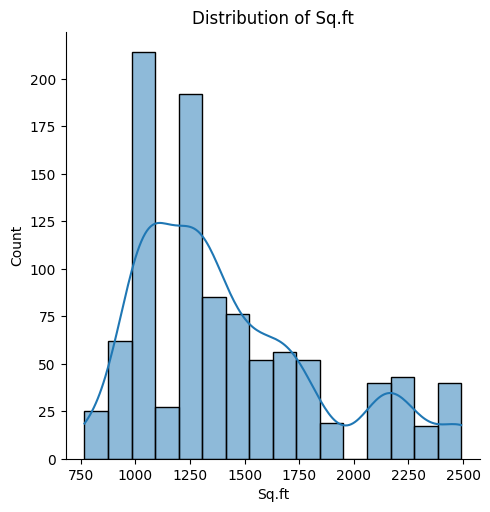

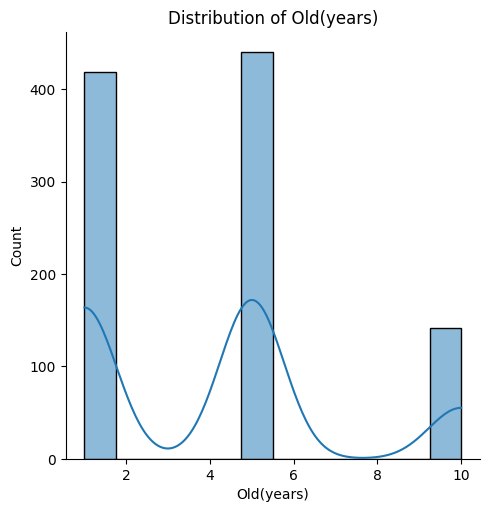

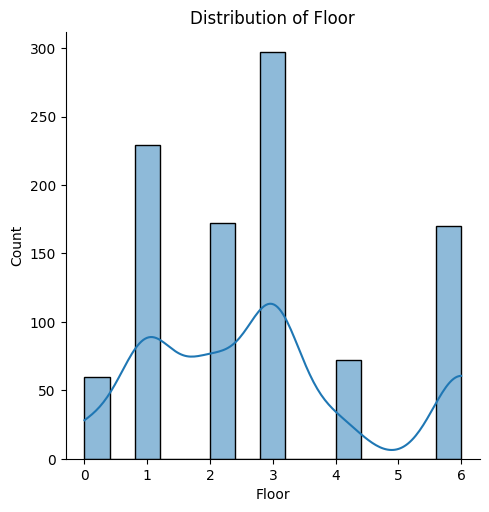

In [22]:
for col in num_cols:
    plot_continuous_distribution(df, col, height = 5)

In [23]:
def continuous_vs_target(df, continuous_variable, target_variable):
    plt.figure(figsize=(7, 5))
    sns.lineplot(x=continuous_variable, y=target_variable, data=df, marker='o', color='b')
    plt.title(f'{continuous_variable} vs {target_variable}', fontsize=14)
    plt.xlabel(continuous_variable, fontsize=12)
    plt.ylabel(target_variable, fontsize=12)
    plt.grid(True)
    plt.show()

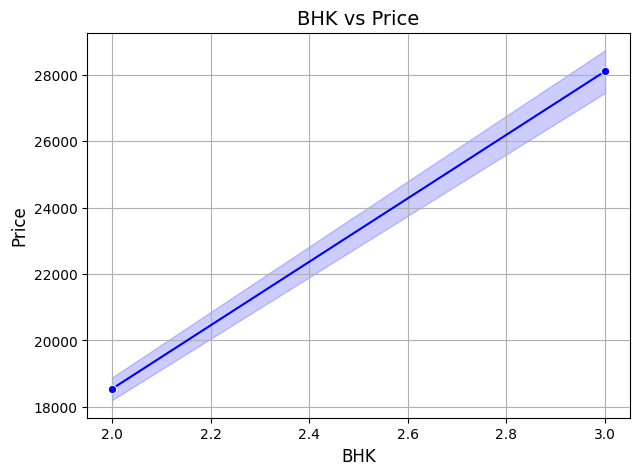

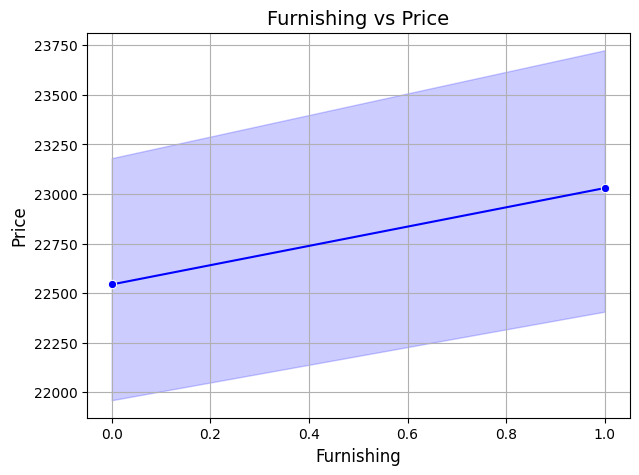

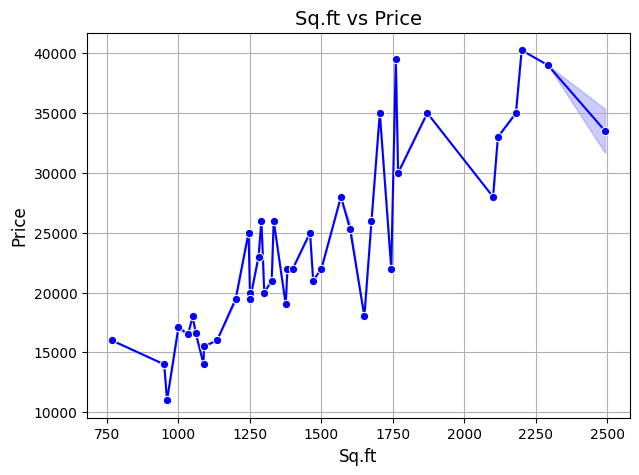

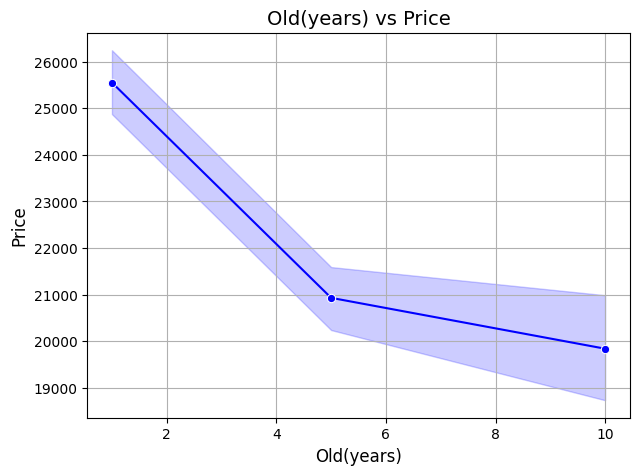

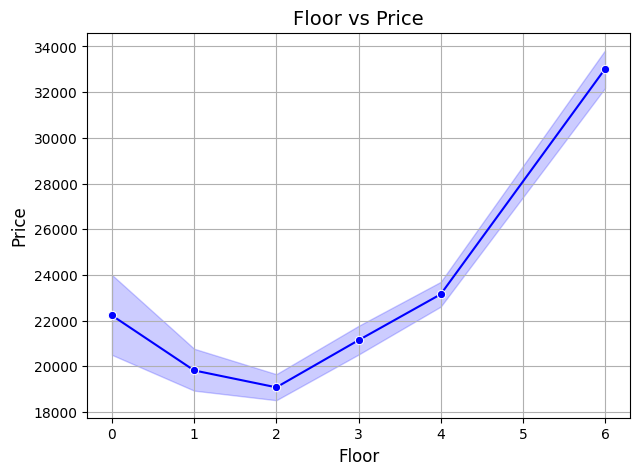

In [24]:
for col in num_cols:
    continuous_vs_target(df, col, 'Price')

In [25]:
def categorical_vs_target(df, cat_var, target_var):
    plt.figure(figsize=(7, 5))
    sns.lineplot(x=cat_var, y=target_var, data=df, marker='o', ci=None)
    plt.title(f'{cat_var} vs {target_var}')
    plt.xlabel(cat_var)
    plt.ylabel(target_var)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

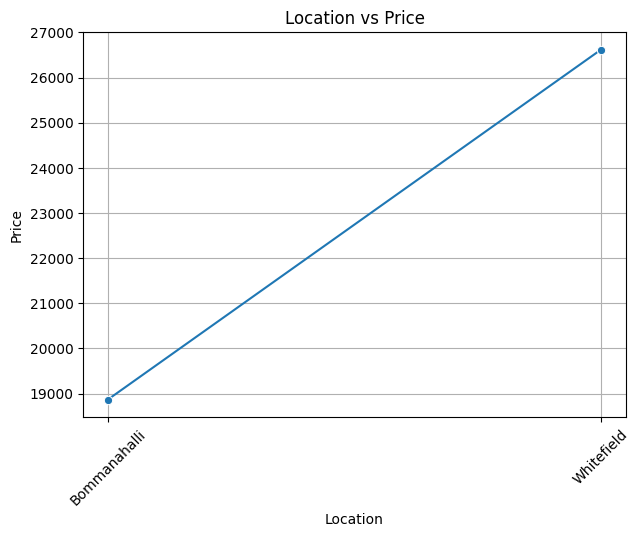

In [26]:
categorical_vs_target(df, 'Location', 'Price')

In [27]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,BHK,Furnishing,Sq.ft,Old(years),Floor,Price
BHK,1.000000,0.136625,0.738118,-0.186380,0.271949,0.640890
Furnishing,0.136625,1.000000,0.033649,0.091563,-0.001950,0.031318
Sq.ft,0.738118,0.033649,1.000000,-0.245641,0.412897,0.864602
Old(years),-0.186380,0.091563,-0.245641,1.000000,-0.221150,-0.301002
Floor,0.271949,-0.001950,0.412897,-0.221150,1.000000,0.555325
Price,0.640890,0.031318,0.864602,-0.301002,0.555325,1.000000


# Insights from data

1. Houses are of 2 to 3 BHK.
2. Maximum square feet is 2500 sqft.
3. BHK, Furnishing, Sq.ft, Old(years) and Floor affects the prices of the house.
4. Categories in location are Whitefield, Bommanahalli.  
5. Houses which are located in Whitefield are expensive then houses in Bommanahalli.

In [28]:
df.to_csv('cleaned_data.csv', index=False)